<a href="https://colab.research.google.com/github/luisdi97/Proyecto_PF-3347/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final Análisis en Ciencia de Datos

### Estudiantes

* Luis Diego Araya Campos
* Cristian Alejandro Herrera Barboza
* Josué Raúl Rivas Muñoz

# 1. Selección del Dataset
Este dataset ha sido seleccionado debido a su relevancia en el contexto de la planificación energética y su aplicabilidad en la creciente adopción de energías renovables, especialmente la energía solar. Dado que uno de los integrantes del grupo tiene acceso a la información requerida, se analiza como una excelente opción la creación de un modelo de aprendizaje que permita optimizar procesos y ayudar en la toma de decisiones que podrían fomentar la eficiencia energética y la sostenibilidad en comunidades locales.

# 2. Descripción del Problema

### Contexto del problema
En el contexto de la transición hacia energías renovables, como la solar, el análisis de la capacidad de instalación de paneles solares en distintos puntos de una red eléctrica es crucial para optimizar el consumo y la generación de energía sostenible. Sin embargo, esta capacidad no es uniforme y depende de varios factores de la red, tales como la capacidad del transformador, la carga actual en kVA, la distancia de los puntos de carga respecto a la subestación y al transformador, entre otros.

Para determinar la viabilidad de la instalación de paneles solares, se realiza un estudio de capacidad de alojamiento mediante software especializado el cual arroja la capacidad de alojamiento para los distintos punto de la red, el cual define el límite máximo de generación que puede ser inyectada en la red sin comprometer la estabilidad del sistema ni exceder la capacidad de los componentes eléctricos, como transformadores y líneas de transmisión. Así, mediante algoritmos de aprendizaje se pretende predecir la máxima capacidad de alojamiento en kW que soportan las ubicaciones donde se pretende instalar un panel.

#### Importancia:
Resolver este problema tiene un impacto directo en la capacidad de planificación y expansión de infraestructuras de energías renovables. Al predecir las capacidades de alojamiento mediante un modelo de aprendizaje se puede agilizar el proceso ya que realizar el mismo cálculo mediante el software especializado puede tardar incluso varios días para los circuitos más grandes, de esta forma también se agiliza la planificación de la red al mostrar los puntos donde podría crecer la generación distribuida y en qué medida.
Por otro lado al permitir la integración de paneles solares de forma segura y óptima reduce la huella de carbono y promueve un uso más ecológico de los recursos eléctricos esto a mismo tiempo que se optimizan los sistemas actuales.

#### Objetivo del Análisis
El objetivo de este análisis es desarrollar un modelo predictivo que estime la capacidad de alojamiento para las distintas ubicaciones en la red en función de variables clave. Este modelo permitirá determinar la capacidad de instalación de paneles solares en cada nodo de carga, facilitando así la toma de decisiones informadas sobre la incorporación de fuentes de energía renovable en cada punto de la red. Al optimizar la asignación de estas instalaciones, se espera que se logren beneficios económicos y ambientales significativos, ayudando a reducir la dependencia de fuentes de energía no renovables y mejorando la eficiencia de la red eléctrica.

#### Supuestos iniciales
De los circuitos de la red eléctrica con datos disponibles para armar el dataset se eligieron aquellos donde no había reguladores o plantas grandes de generación privada, de manera que se simplifica el problema a resolver. Por otro lado, como se muestra en el preprocesamiento del dataset se eliminan las instancias que tienen asociados transformadores grandes o que presentaran generación distribuida por lo cual se espera que hayan pocos o ningunos outliers. De esta forma se espera que el dataset sea de baja dificultad logrando que los modelos se sintonizen de manera sencilla y presenten buenas métricas.

# 3. Preprocesamiento del Dataset
Se realiza un preprocesamiento para asegurar la consistencia, relevancia y calidad de la información, se agrega una columna extra donde se realiza un conteo del número de entradas por circuito lo cual representa el número de clientes monofásicos del circuito y da una idea del tamaño del circuito que es un aspecto que afecta los resultados del análisis de capacidad de alojamiento, para ello se agrupan las instancias por el identificador de la red (Network Id).
Se seleccionaron únicamente las filas donde la generación distribuida es igual a 0.0, es decir, aquellas sin generación adicional en las cargas para simplificar el modelo ya que si ya existe generación distribuida en el punto la generación adicional arrojada por el software especializado es menor.
Además se deben filtrar las filas para excluir cualquier valor de carga negativo o inválido ('Load (kVA)' >= 0.0). Esto garantiza que solo se consideren valores positivos y realistas de carga, lo que mejora la precisión del modelo.
Como dato adicional es importante restringir el dataset a transformadores con una capacidad máxima de 50 kVA, para centrar el análisis en transformadores de menor capacidad, típicos de instalaciones residenciales o comerciales pequeñas. Este enfoque asegura que el modelo se optimice para escenarios en los que la carga y la capacidad son limitadas, ya que los de mayor capacidad pueden generar ruido en los datos y bajar la precisión del modelo.
Las features más relevantes seleccionadas permiten mejorar los resultados, incluyendo capacidad del transformador, impedancia, carga en kVA, número de nodos de carga, y distancias de conexión (del punto a la subestación y del punto al transformador). Estas variables permiten al modelo aprender patrones importantes para la predicción de la capacidad de carga de la red.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('datos_IA_ICA.csv')
df

,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,Distributed Generation per Load (kW),IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW)
0,0,66.227012,IC Loading (kW),92.834901,100.000000,100.0,100.000000,66.227012,NaN,1757500_T,...,0.00,66.227012,IC Loading (kW),46.701847,1,0.00,6231.403964,0.0,0.0,NaN
1,0,39.338502,IC Loading (kW),44.136866,76.979637,100.0,55.816274,39.338502,NaN,1570287_T,...,0.00,39.338502,IC Loading (kW),15.867834,1,0.00,6299.541223,0.0,0.0,NaN
2,0,32.842440,IC Loading (kW),42.906003,74.829132,100.0,76.850072,32.842440,NaN,1570288_T,...,0.00,32.842440,IC Loading (kW),23.350922,1,0.00,6300.676739,0.0,0.0,NaN
3,0,32.842441,IC Loading (kW),42.897159,74.813462,100.0,76.875324,32.842441,NaN,3543374_T,...,0.00,32.842441,IC Loading (kW),23.350922,1,0.00,6366.654858,0.0,0.0,NaN
4,0,13.608194,IC Loading (kW),18.157137,31.730709,100.0,19.124799,13.608194,NaN,300380_T,...,0.00,13.608194,IC Loading (kW),4.294494,1,0.00,9189.457160,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83561,29,95.966316,IC Loading (kW),1000.000000,422.193711,NaN,539.364952,95.966316,186.555865,894463_T,...,0.00,95.966316,IC Loading (kW),45.856394,2,0.00,11443.200000,8.8,8.8,NaN
83562,29,133.749377,IC Loading (kW),1000.000000,450.027015,NaN,609.635581,133.749377,187.517309,894463_T,...,0.00,95.966316,IC Loading (kW),45.856394,2,0.00,11442.100000,7.7,8.8,NaN
83563,29,247.742728,IC Loading (kW),1000.000000,1000.000000,NaN,490.543335,247.742728,287.550202,894465_T,...,0.00,247.742728,IC Loading (kW),103.115261,1,0.00,17169.400000,2.8,2.8,NaN
83564,29,14.863747,IC Loading (kW),1000.000000,553.675056,NaN,579.989884,14.863747,181.518313,894464_T,...,105.05,14.863747,IC Loading (kW),29.009023,1,105.05,17001.700000,2.5,2.5,NaN


In [3]:
df_final = df.copy()

df_final['Num_Nodos_Load'] = df_final.groupby('Network Id')['Network Id'].transform('count')

In [4]:
df_final = df_final.loc[df_final['Distributed Generation per Load (kW)'] == 0.0].copy()

In [5]:
df_final = df_final.loc[df_final['Load (kVA)'] >= 0.0].copy()

In [6]:
kVA_transformers = list(df_final['Transformer Capacity (kVA)'].unique())
kVA_transformers.sort()
kVA_transformers

[10.0,
 15.0,
 20.0,
 25.0,
 30.0,
 32.5,
 35.0,
 37.5,
 40.0,
 45.0,
 50.0,
 52.5,
 55.0,
 60.0,
 62.5,
 65.0,
 75.0,
 85.0,
 87.5,
 100.0,
 110.0,
 112.5,
 113.0,
 115.0,
 125.0,
 137.5,
 150.0,
 160.0,
 167.0,
 175.0,
 185.0,
 200.0,
 225.0,
 250.0,
 300.0,
 310.0,
 400.0,
 500.0,
 501.0,
 511.0,
 750.0,
 999.0,
 1000.0,
 1500.0,
 2000.0,
 2500.0,
 3000.0]

In [7]:
df_final = df_final.loc[df_final['Transformer Capacity (kVA)'] <= 50.0].copy()

In [8]:
# Verifico que no hayan valores nulos, en las columnas que se utilizarán para el análisis:
print(
    df_final[
        [
            'Transformer Capacity (kVA)',
            'Total Path Z (Ω)',
            'Load (kVA)',
            'Number of Load Nodes',
            'Distance from substation to Load (m)',
            'Distance from transformer to Load (m)',
            'Num_Nodos_Load','IC Max per Load (kW)',
        ]
    ].isnull().sum()
)

duplicated_rows = df_final.duplicated()
# Mostrar todas las filas duplicadas si existen
df_final[duplicated_rows]

Transformer Capacity (kVA)               0
Total Path Z (Ω)                         0
Load (kVA)                               0
Number of Load Nodes                     0
Distance from substation to Load (m)     0
Distance from transformer to Load (m)    0
Num_Nodos_Load                           0
IC Max per Load (kW)                     0
dtype: int64


,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load


In [9]:
# Se imprime la descrición de los datos con los que contamos
df_final.describe()

,Network Id,IC Max per Load (kW),IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),Transformer Capacity (kVA),Total Path R (Ω),...,Distributed Generation per Load (kW),IC Max per Transfomer (kW),Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load
count,78874.000000,78874.000000,44291.000000,64813.000000,26084.000000,78874.000000,78874.000000,16860.000000,78874.000000,78874.000000,...,78874.0,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,143.000000,78874.000000
mean,15.089801,14.464479,398.150456,28.196298,146.938880,18.321903,29.199188,111.927309,33.394116,0.025816,...,0.0,8.853498,13.365612,36.433945,0.235691,8338.843016,79.160900,155.614716,165.914297,11620.933996
std,10.491261,6.826073,457.746878,108.726261,100.935905,11.091508,23.381465,57.456808,15.331889,0.029364,...,0.0,5.161798,9.431816,22.230790,1.920446,5967.273500,59.469581,80.285128,59.771078,5074.972875
min,0.000000,0.000000,0.000008,0.552629,25.000000,0.316605,0.000000,1.412488,10.000000,0.000000,...,0.0,0.000000,-9.527180,1.000000,0.000000,95.653982,0.000000,0.000000,14.418919,11.000000
25%,3.000000,10.100000,100.000000,12.776153,100.000000,11.497769,18.263682,65.601447,25.000000,0.013842,...,0.0,5.958652,6.931338,21.000000,0.000000,3990.004026,35.900000,104.200000,166.994083,9043.000000
50%,17.000000,14.625825,200.000000,18.711324,100.000000,16.457898,19.859683,102.748763,25.000000,0.020141,...,0.0,8.600000,11.094322,34.000000,0.000000,6425.417874,64.900000,140.500000,200.000000,11910.000000
75%,27.000000,18.211141,433.959961,27.526867,100.000000,22.884367,22.079200,149.432343,50.000000,0.027550,...,0.0,11.300000,17.480326,48.000000,0.000000,11863.817472,107.400000,194.600000,200.000000,14593.000000
max,29.000000,97.578440,3000.000000,4577.688918,1000.000000,203.103403,353.240967,417.832079,50.000000,1.204620,...,0.0,97.578440,49.509482,184.000000,50.000000,36350.731352,1153.800000,1153.800000,200.000000,18157.000000


In [10]:
df_final

,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load
0,0,66.227012,IC Loading (kW),92.834901,100.000000,100.0,100.000000,66.227012,NaN,1757500_T,...,66.227012,IC Loading (kW),46.701847,1,0.0,6231.403964,0.0,0.0,NaN,842
1,0,39.338502,IC Loading (kW),44.136866,76.979637,100.0,55.816274,39.338502,NaN,1570287_T,...,39.338502,IC Loading (kW),15.867834,1,0.0,6299.541223,0.0,0.0,NaN,842
2,0,32.842440,IC Loading (kW),42.906003,74.829132,100.0,76.850072,32.842440,NaN,1570288_T,...,32.842440,IC Loading (kW),23.350922,1,0.0,6300.676739,0.0,0.0,NaN,842
3,0,32.842441,IC Loading (kW),42.897159,74.813462,100.0,76.875324,32.842441,NaN,3543374_T,...,32.842441,IC Loading (kW),23.350922,1,0.0,6366.654858,0.0,0.0,NaN,842
4,0,13.608194,IC Loading (kW),18.157137,31.730709,100.0,19.124799,13.608194,NaN,300380_T,...,13.608194,IC Loading (kW),4.294494,1,0.0,9189.457160,0.0,0.0,NaN,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83545,29,1.412488,IC Fault Current Variation (kW),1000.000000,68.665465,NaN,66.413684,42.312307,1.412488,2720440_T,...,1.412488,IC Fault Current Variation (kW),0.000000,3,0.0,11600.000000,4.1,4.1,NaN,18157
83546,29,31.310848,IC Loading (kW),1000.000000,63.075676,NaN,60.435768,31.310848,140.001965,2720440_T,...,1.412488,IC Fault Current Variation (kW),0.000000,3,0.0,11597.900000,2.0,4.1,NaN,18157
83547,29,57.788939,IC Volt Variation BT (kW),1000.000000,57.788939,NaN,92.684883,74.334808,137.706260,2720435_T,...,57.788939,IC Volt Variation BT (kW),30.151610,1,0.0,11296.100000,8.1,8.1,NaN,18157
83548,29,29.221530,IC Volt Limits (kW),1000.000000,37.569792,NaN,29.221530,33.540510,124.356774,2600762_T,...,25.890211,IC Volt Limits (kW),1.990006,2,0.0,7076.200000,14.1,18.3,NaN,18157


In [11]:
features = [
    'Transformer Capacity (kVA)',
    'Total Path Z (Ω)',
    'Load (kVA)',
    'Number of Load Nodes',
    'Distance from substation to Load (m)',
    'Distance from transformer to Load (m)',
    'Num_Nodos_Load',
]

target = 'IC Max per Load (kW)'

In [12]:
X = df_final.loc[:, features].copy()
y = df_final.loc[:, target].copy()

In [13]:
# Para el uso de KNN es necesario normalizar las características:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Implementación de KNN

In [13]:
#Librerías
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# División del dataset en entrenamiento y prueba para KNN. Es diferente de los demás algoritmos, ya que en este se usa el X escalado
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verificar los tamaños de los conjuntos
print(f"Conjunto de entrenamiento: {X_train_knn.shape}")
print(f"Conjunto de prueba: {X_test_knn.shape}")

Conjunto de entrenamiento: (63099, 7)
Conjunto de prueba: (15775, 7)


In [ ]:
# Crear el modelo KNN
knn = KNeighborsRegressor(n_neighbors=5)  # Este es el hiperparámetro que se ajusta en KNN idealmente inicia en 5

# Entrenar el modelo
knn.fit(X_train_knn, y_train_knn)

# Realizar predicciones
knn_y_pred = knn.predict(X_test_knn)

In [ ]:
# Análisis de las métricas
mse = mean_squared_error(y_test_knn, knn_y_pred)
rmse = root_mean_squared_error(y_test_knn, knn_y_pred)
r2 = r2_score(y_test_knn, knn_y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = knn.score(X_train_knn, y_train_knn)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = knn.score(X_test_knn, y_test_knn)

# Calculo del MAE
mae_knn = mean_absolute_error(y_test_knn, knn_y_pred)

print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")

print(f"MAE: {mae_knn}")

Mean Squared Error: 8.660096499716033
Root Mean Squared Error: 2.942804189835952
R^2 Score: 0.8134536211746145
Training Score (R²): 0.8806124478581538
Testing Score (R²): 0.8134536211746145
MAE: 1.4717572289231113


# Análisis de resultados de KNN
Se determina que deben haber mejores hiperparámetros, por lo que se intenta revisar cual es el mejor numero de vecinos (n_neighbors). Para esto se hace un análisis desde 1 hasta 21:

Mejor valor de n_neighbors: 3


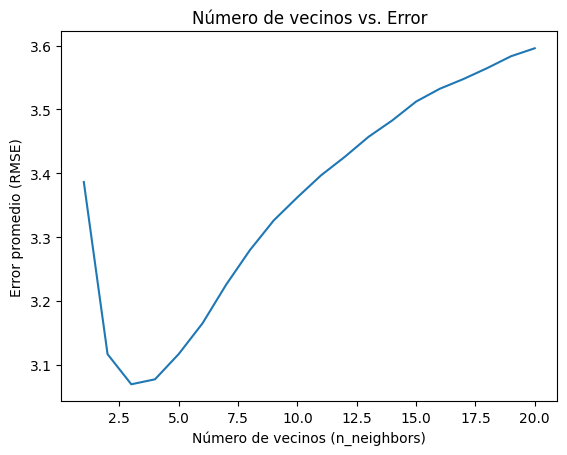

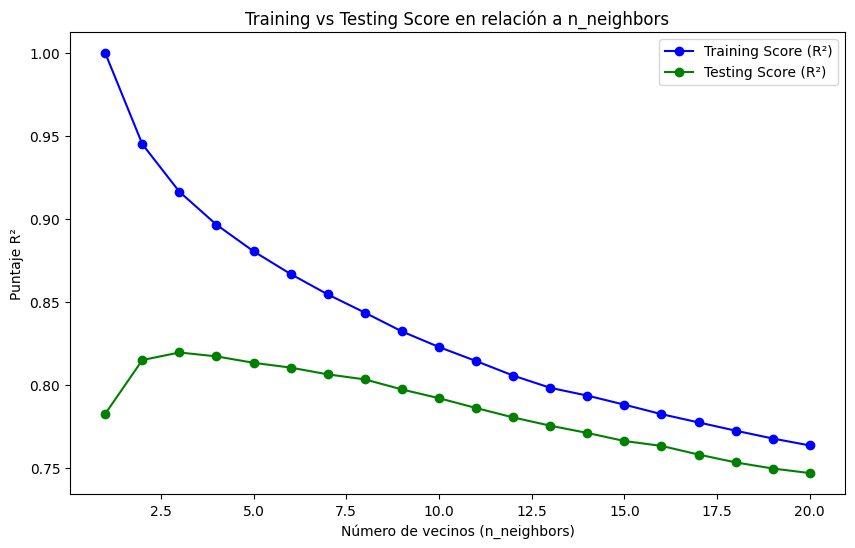

In [18]:
scores = []
train_scores = []
test_scores = []

# print(X_train_knn)  # Esto mostrará los valores en el arreglo

# Probar diferentes valores de n_neighbors
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors=k)
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(knn, X_train_knn, y_train_knn, cv=5, scoring='neg_root_mean_squared_error')

    knn.fit(X_train_knn, y_train_knn)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(knn.score(X_train_knn, y_train_knn))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(knn.score(X_test_knn, y_test_knn))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_neighbors con el menor error
best_k = np.argmin(scores) + 1
print(f"Mejor valor de n_neighbors: {best_k}")

# Graficar los puntajes
plt.plot(range(1, 21), scores)
plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de vecinos vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range(1, 21), test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_neighbors')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

El resultado del análisis indica que el mejor numero de vecinos es 3, por lo que se ejecuta el algoritmo con este valor y se vuelven a imprimir las metricas


In [ ]:
knn = KNeighborsRegressor(n_neighbors=3)  # Este es el hiperparámetro que se ajusta en KNN idealmente inicia en 5
# Entrenar el modelo
knn.fit(X_train_knn, y_train_knn)
# Realizar predicciones
knn_y_pred = knn.predict(X_test_knn)

mse = mean_squared_error(y_test_knn, knn_y_pred)
rmse = root_mean_squared_error(y_test_knn, knn_y_pred)
r2 = r2_score(y_test_knn, knn_y_pred)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = knn.score(X_train_knn, y_train_knn)
# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = knn.score(X_test_knn, y_test_knn)
# Calculo del MAE
mae_knn = mean_absolute_error(y_test_knn, knn_y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_knn}")

Mean Squared Error: 8.371039606899624
Root Mean Squared Error: 2.893274893075254
R^2 Score: 0.8196801703396484
Training Score (R²): 0.9164726568566212
Testing Score (R²): 0.8196801703396484
MAE: 1.3640569715462674


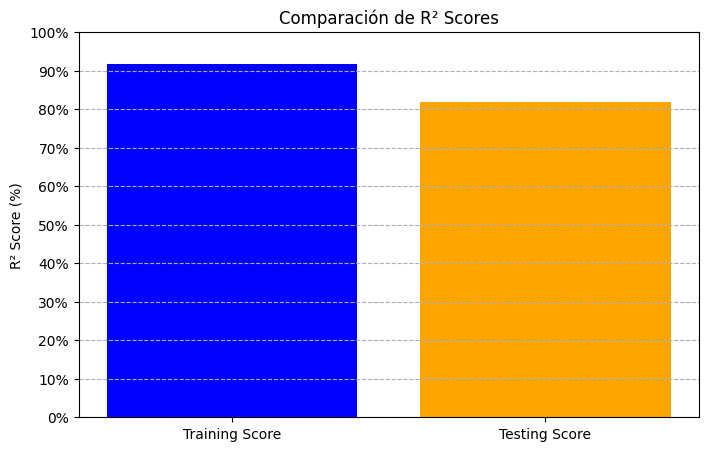

In [20]:
# Con los datos obtenidos se imprimen los resultados:
# Valores de R²
scores = [train_score, test_score]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

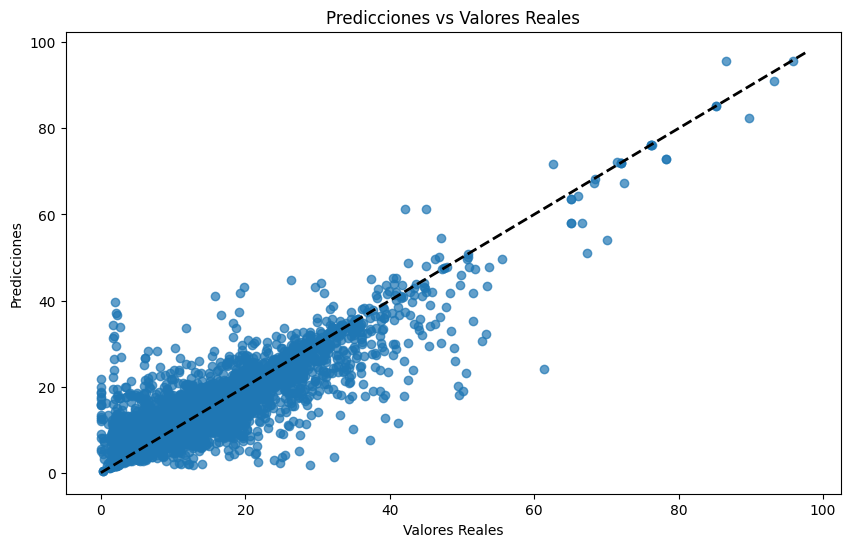

In [21]:
# se realiza un análisis de la predicción de los valores:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_knn, knn_y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

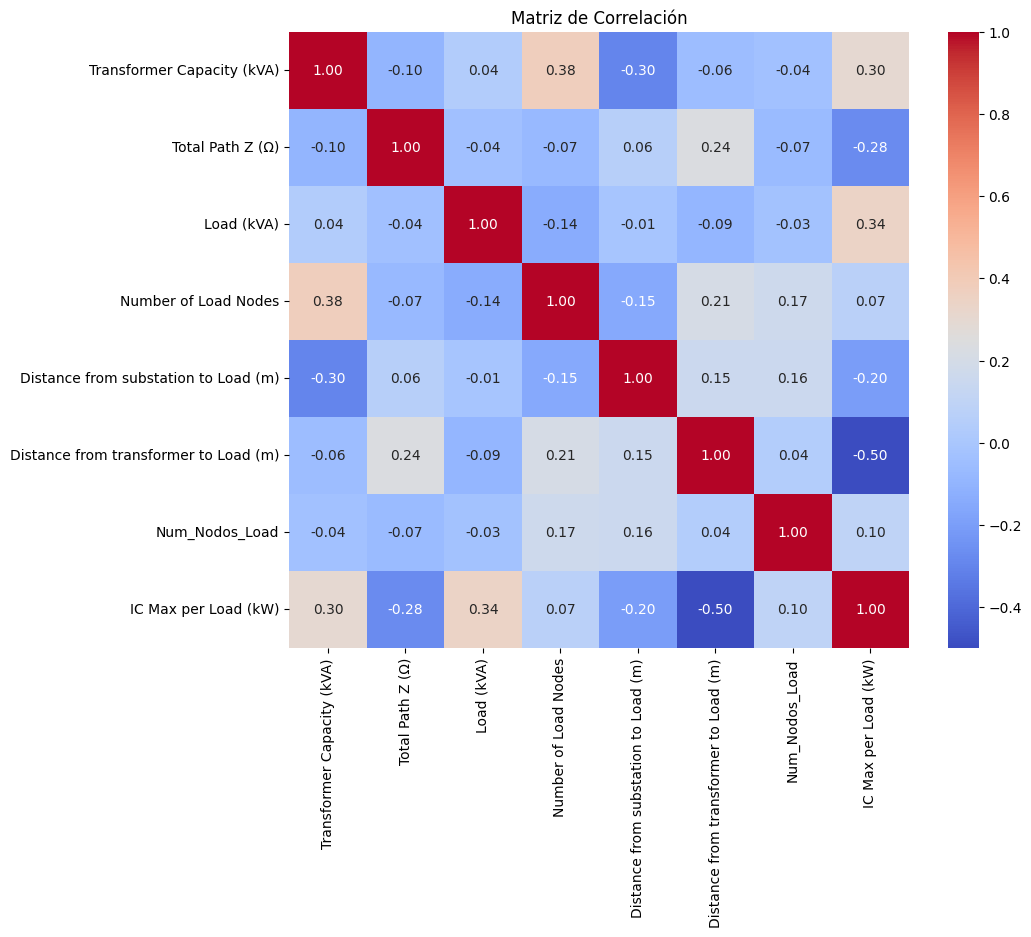

In [ ]:
# Con los valores obtenidos y para un mejor análisis se crea una matriz de correlación
# Crear una matriz de correlación
correlacion = df_final[[
    'Transformer Capacity (kVA)',
    'Total Path Z (Ω)',
    'Load (kVA)',
    'Number of Load Nodes',
    'Distance from substation to Load (m)',
    'Distance from transformer to Load (m)',
    'Num_Nodos_Load',
    'IC Max per Load (kW)'
]].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

In [14]:
# Entrenamiento para los demás modelos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [25]:
# Entrenar el modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [26]:
# Se calculan las metricas del Random Forest.
# Calcular las métricas
mse = mean_squared_error(y_test, y_pred_rf)
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = rf.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = rf.score(X_test, y_test)

# Calculo del MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_rf}")

Mean Squared Error: 5.749554407971958
Root Mean Squared Error: 2.3978228474956107
R^2 Score: 0.8761493529890954
Training Score (R²): 0.9811736633575577
Testing Score (R²): 0.8761493529890954
MAE: 1.283374780005728


Para mejorar los resultados se realiza una busqueda de Grid Search para encontrar los mejores parámetros.


In [ ]:
# Definir los parámetros a probar
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42) # n_estimators=10 da un muy buen resultado ;Mean Squared Error (Random Forest): 40.11068269701386 y R² Score (Random Forest): 0.902790660423813
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=10,
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Tiempo estimado: 30 min

'\n# Definir los parámetros a probar\nparam_grid = {\n    \'n_estimators\': [10, 50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\']\n}\n\nrf = RandomForestRegressor(random_state=42) # n_estimators=10 da un muy buen resultado ;Mean Squared Error (Random Forest): 40.11068269701386 y R² Score (Random Forest): 0.902790660423813\ngrid_search = GridSearchCV(\n    estimator=rf,\n    param_grid=param_grid,\n    cv=5,\n    n_jobs=-1,\n    verbose=10,\n)\n\n# Entrenar el modelo\ngrid_search.fit(X_train, y_train)\n\n# Realizar predicciones en el conjunto de prueba\nprint("Mejores parámetros encontrados:", grid_search.best_params_)\n\n# Tiempo estimado: 30 min\n'

El resultado del Grid Search indica:
Mejores parámetros encontrados: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Por lo que se ejecuta el algoritmo con dichos parámetros

In [28]:
best_rf = RandomForestRegressor(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

best_rf.fit(X_train, y_train)

y_pred_best_rf = best_rf.predict(X_test)

# Evaluar el modelo
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = root_mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

train_score = best_rf.score(X_train, y_train)

test_score = best_rf.score(X_test, y_test)

mae_rfb = mean_absolute_error(y_test, y_pred_best_rf)
print(f'Mean Squared Error (Mejor Random Forest): {mse_best_rf}')
print(f'Root Mean Squared Error (Mejor Random Forest): {rmse_best_rf}')
print(f'R² Score (Mejor Random Forest): {r2_best_rf}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_rfb}")

Mean Squared Error (Mejor Random Forest): 5.95865748121562
Root Mean Squared Error (Mejor Random Forest): 2.4410361491005452
R² Score (Mejor Random Forest): 0.8716450820359779
Training Score (R²): 0.981951084216809
Testing Score (R²): 0.8716450820359779
MAE: 1.3488703394791421


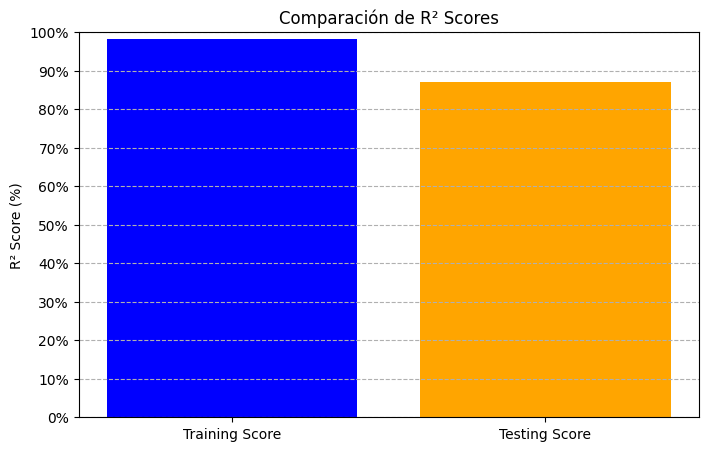

In [29]:
# Se grafican los resultados obtenidos:
# Valores de R²
scores = [train_score, test_score]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

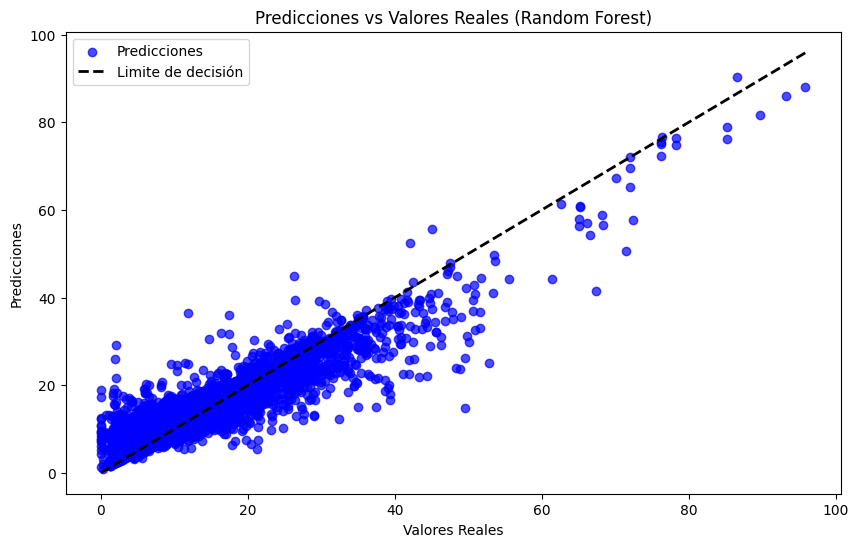

In [30]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Random Forest)')
plt.legend()
plt.show()

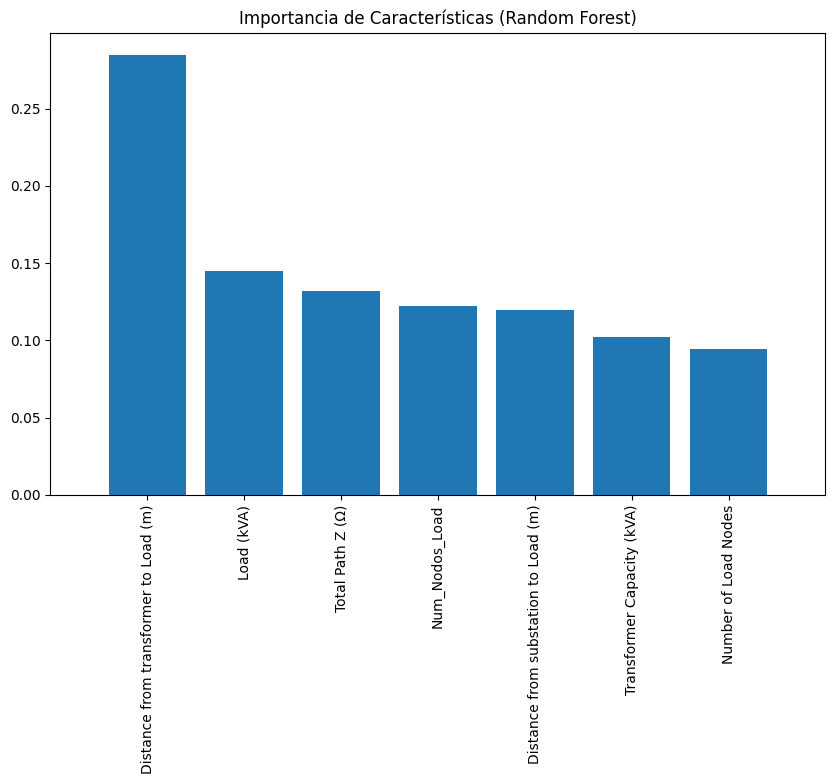

In [31]:
# Se analiza la importancia de las caracteristicas en Random Forest:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características (Random Forest)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# GradientBoostingRegressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
# Parámetros iniciales

params = {
    # "loss": "squared_error",
    # "learning_rate": 0.1,
    # "n_estimators": 100,
    # "subsample": 1.0,
    # "criterion": "friedman_mse",
    # "min_samples_split": 2,
    # "min_samples_leaf": 1,
    # "min_weight_fraction_leaf": 0.0,
    # "max_depth": 3,
    # "min_impurity_decrease": 0.0,
    # "init": None,
    "random_state": 42,
    # "max_features": None,
    # "alpha": 0.9,
    # "verbose": 0,
    # "max_leaf_nodes": None,
    # "warm_start": False,
    # "validation_fraction": 0.1,
    # "n_iter_no_change": None,
    # "tol": 0.0001,
    # "ccp_alpha": 0.0,
}

In [34]:
# Crear el modelo
reg = GradientBoostingRegressor(**params)

# Entrenar el modelo
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [35]:
# Realizar predicciones
y_pred_gbr = reg.predict(X_test)

In [36]:
# Calcular las métricas
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = root_mean_squared_error(y_test, y_pred_gbr)
r2 = r2_score(y_test, y_pred_gbr)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = reg.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = reg.score(X_test, y_test)

# Calculo del MAE
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_gbr}")

Mean Squared Error: 16.363314457832903
Root Mean Squared Error: 4.0451593859615596
R^2 Score: 0.6475192790530802
Training Score (R²): 0.6648771438215115
Testing Score (R²): 0.6475192790530802
MAE: 2.583384619856514


Mejor valor de n_estimators: 998


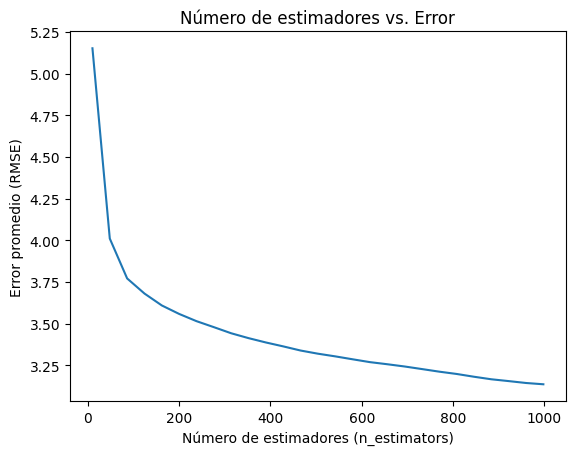

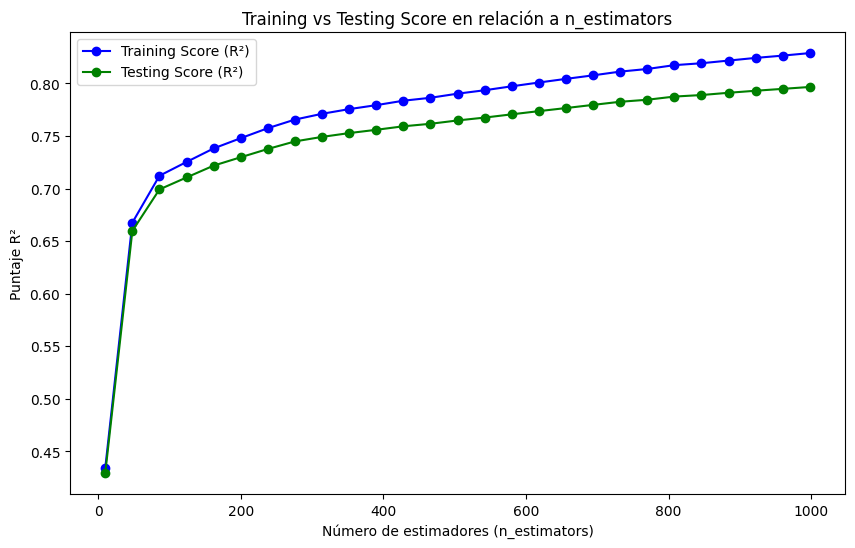

In [37]:
scores = []
train_scores = []
test_scores = []

# print(X_train)  # Esto mostrará los valores en el arreglo

range_test = range(10, 1036, 38)

# Probar diferentes valores de n_estimators
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=n,
        min_samples_split=600,
        min_samples_leaf=60,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_estimators con el menor error
best_n = 10 + np.argmin(scores)*38
print(f"Mejor valor de n_estimators: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de estimadores vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_estimators')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Tiempo estimado: 274 min

Mejor valor de min_samples_split: 2


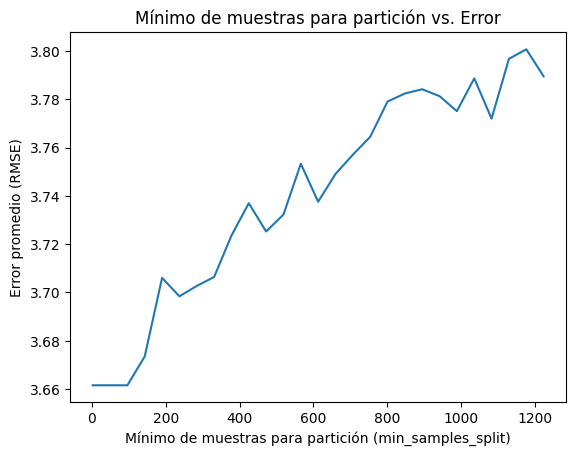

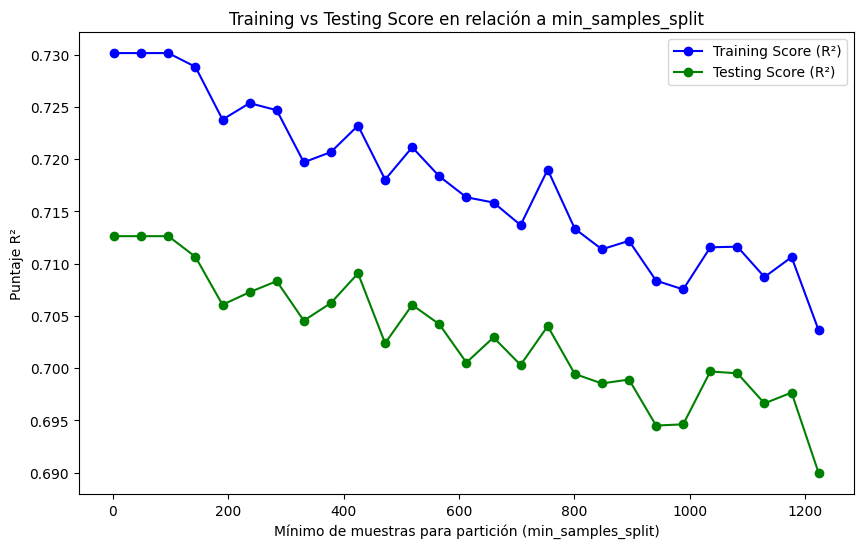

In [38]:
scores = []
train_scores = []
test_scores = []

# print(X_train)  # Esto mostrará los valores en el arreglo

range_test = range(2, 1271, 47)

# Probar diferentes valores de min_samples_split
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=n,
        min_samples_leaf=60,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_split con el menor error
best_n = 2 + np.argmin(scores)*47
print(f"Mejor valor de min_samples_split: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras para partición vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_split')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Tiempo estimado: 274 min

Mejor valor de min_samples_leaf: 6


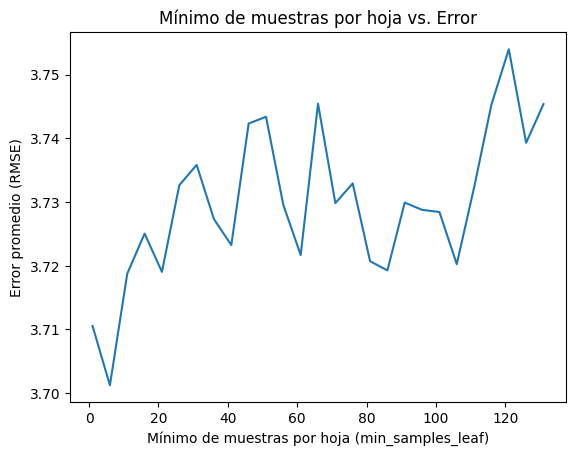

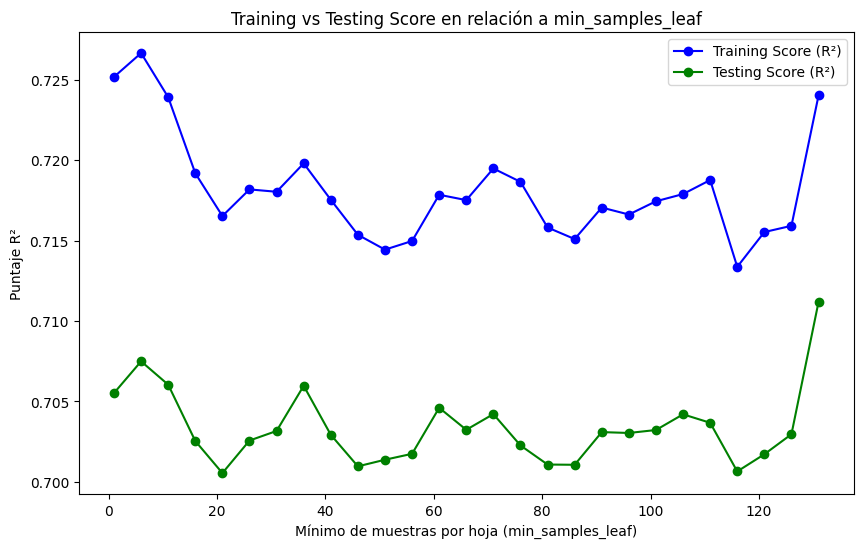

In [39]:
scores = []
train_scores = []
test_scores = []

# print(X_train)  # Esto mostrará los valores en el arreglo

range_test = range(1, 136, 5)

# Probar diferentes valores de min_samples_leaf
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=600,
        min_samples_leaf=n,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_leaf con el menor error
best_n = 1 + np.argmin(scores)*5
print(f"Mejor valor de min_samples_leaf: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras por hoja vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_leaf')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Tiempo estimado: 274 min

Mejor valor de max_depth: 27


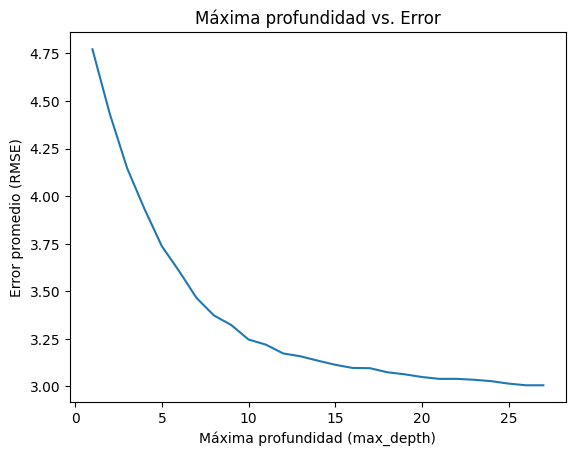

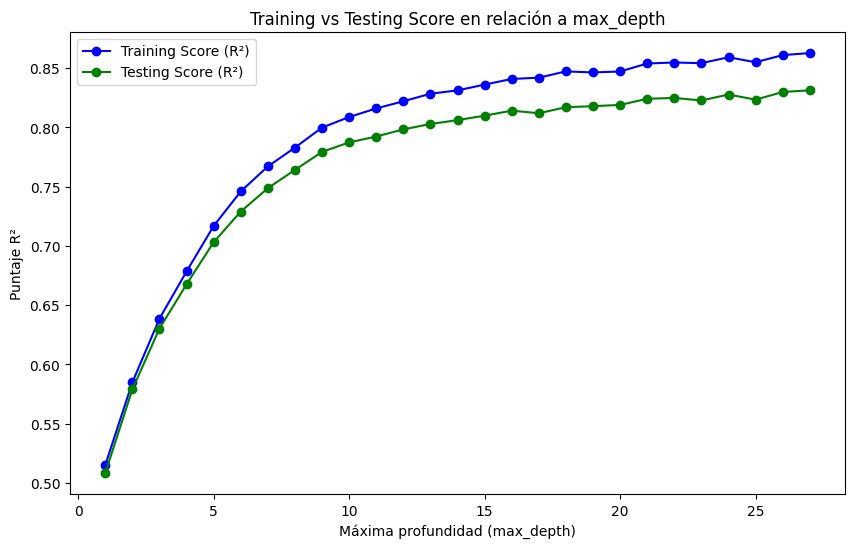

In [40]:
scores = []
train_scores = []
test_scores = []

# print(X_train)  # Esto mostrará los valores en el arreglo

range_test = range(1, 28)

# Probar diferentes valores de max_depth
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=600,
        min_samples_leaf=60,
        max_depth=n,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de max_depth con el menor error
best_n = np.argmin(scores) + 1
print(f"Mejor valor de max_depth: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Máxima profundidad vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a max_depth')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Tiempo estimado: 274 min

In [18]:
best_grb = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=6,
    max_depth=27,
    random_state=42,
    max_features='sqrt',
)

best_grb.fit(X_train, y_train)

y_pred_best_grb = best_grb.predict(X_test)

# Evaluar el modelo
mse_best_grb = mean_squared_error(y_test, y_pred_best_grb)
rmse_best_grb = root_mean_squared_error(y_test, y_pred_best_grb)
r2_best_grb = r2_score(y_test, y_pred_best_grb)

train_score = best_grb.score(X_train, y_train)

test_score = best_grb.score(X_test, y_test)

mae_best_grb = mean_absolute_error(y_test, y_pred_best_grb)
print(f'Mean Squared Error (Mejor Gradient Boosting): {mse_best_grb}')
print(f'Root Mean Squared Error (Mejor Gradient Boosting): {rmse_best_grb}')
print(f'R² Score (Mejor Gradient Boosting): {r2_best_grb}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_best_grb}")

Mean Squared Error (Mejor Gradient Boosting): 4.527623305259856
Root Mean Squared Error (Mejor Gradient Boosting): 2.127821257826854
R² Score (Mejor Gradient Boosting): 0.9024708636550015
Training Score (R²): 0.9966088195231736
Testing Score (R²): 0.9024708636550015
MAE: 1.1533018721839663


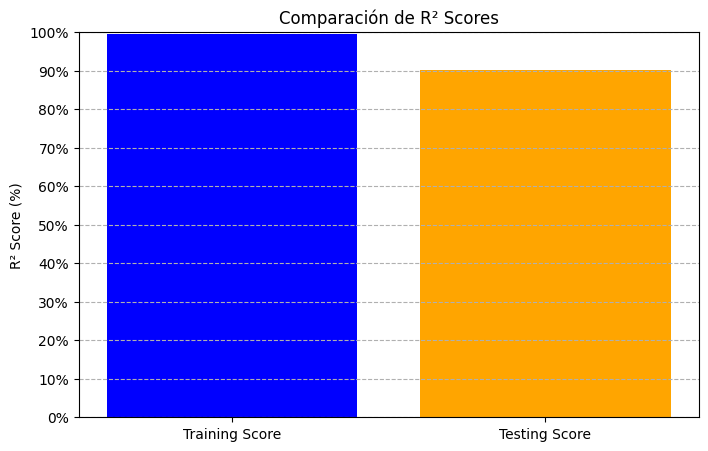

In [19]:
# Se grafican los resultados obtenidos:
# Valores de R²
scores = [train_score, test_score]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

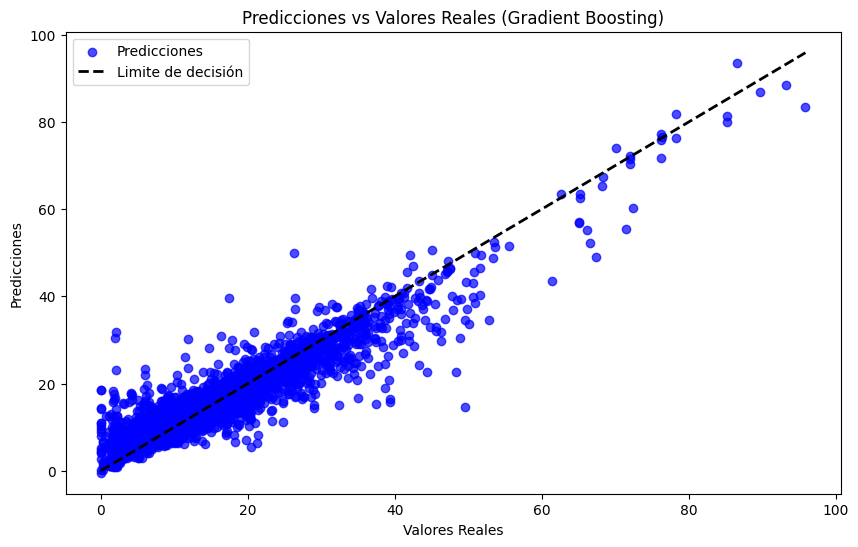

In [20]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_grb, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Gradient Boosting)')
plt.legend()
plt.show()

Mejor valor de min_samples_split: 25


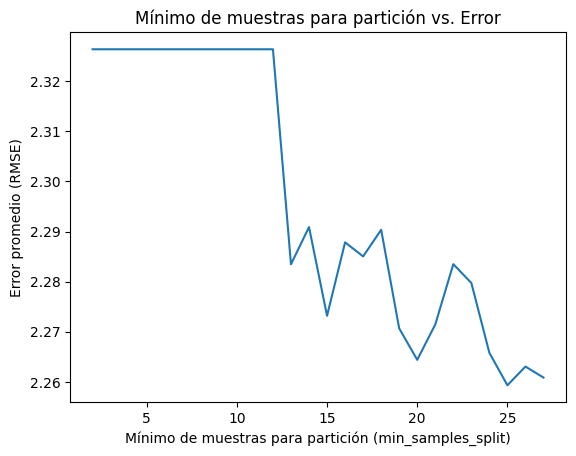

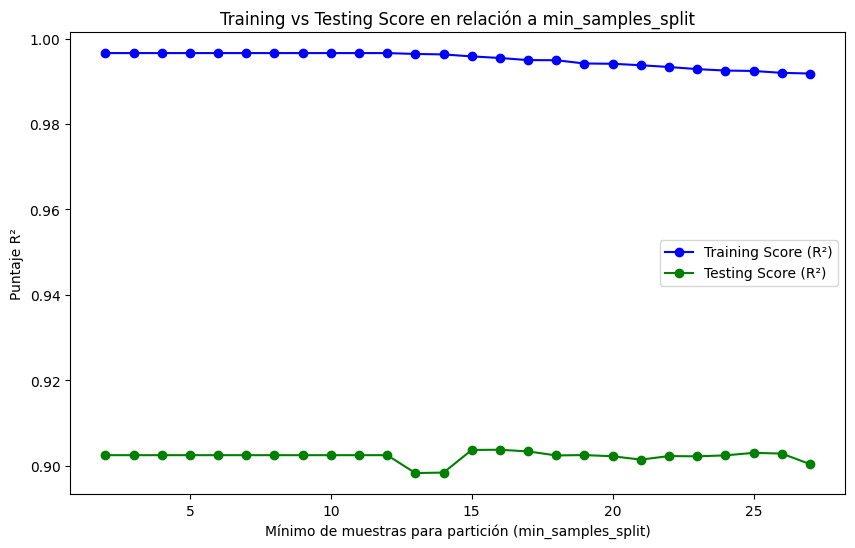

In [17]:
scores = []
train_scores = []
test_scores = []

# print(X_train)  # Esto mostrará los valores en el arreglo

range_test = range(2, 28)

# Probar diferentes valores de min_samples_split
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=n,
        min_samples_leaf=6,
        max_depth=27,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_split con el menor error
best_n = 2 + np.argmin(scores)
print(f"Mejor valor de min_samples_split: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras para partición vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_split')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Tiempo estimado: 274 min

Mejor valor de min_samples_leaf: 8


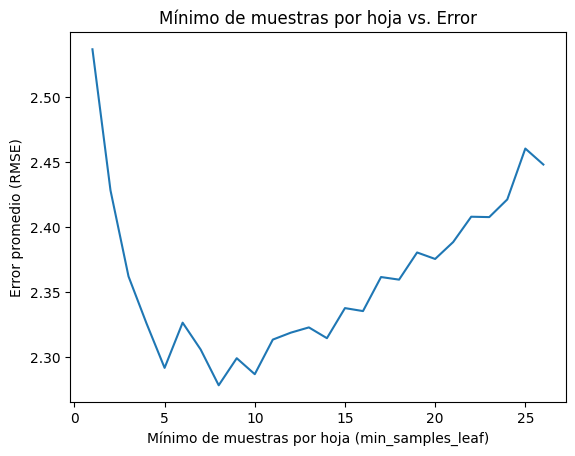

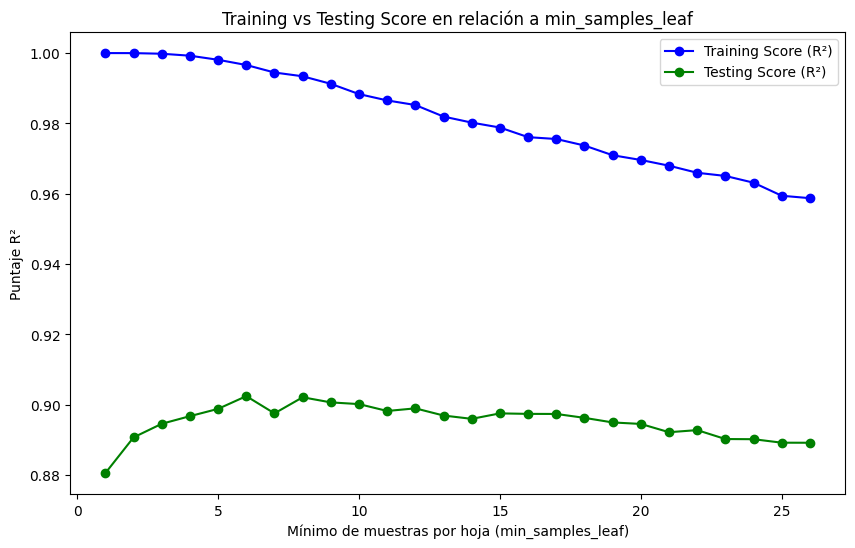

In [18]:
scores = []
train_scores = []
test_scores = []

# print(X_train)  # Esto mostrará los valores en el arreglo

range_test = range(1, 27)

# Probar diferentes valores de min_samples_leaf
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=n,
        max_depth=27,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_leaf con el menor error
best_n = 1 + np.argmin(scores)
print(f"Mejor valor de min_samples_leaf: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras por hoja vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_leaf')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Tiempo estimado: 274 min

Mejor valor de max_depth: 23


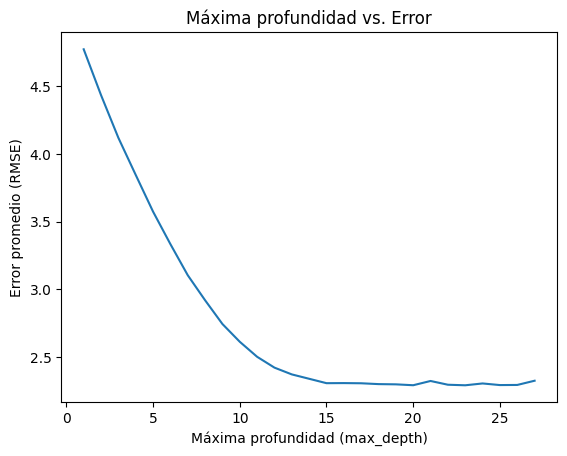

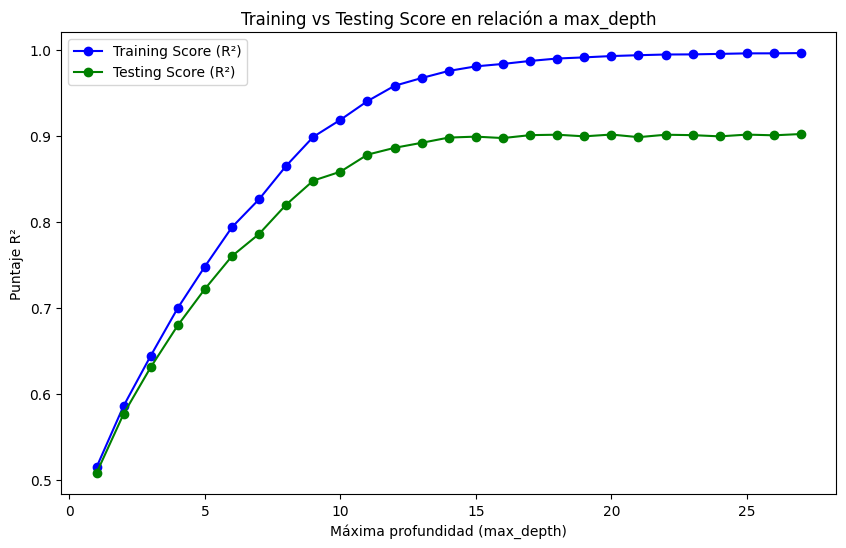

In [19]:
scores = []
train_scores = []
test_scores = []

# print(X_train)  # Esto mostrará los valores en el arreglo

range_test = range(1, 28)

# Probar diferentes valores de max_depth
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=6,
        max_depth=n,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de max_depth con el menor error
best_n = np.argmin(scores) + 1
print(f"Mejor valor de max_depth: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Máxima profundidad vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a max_depth')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Tiempo estimado: 274 min